In [34]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
%matplotlib inline

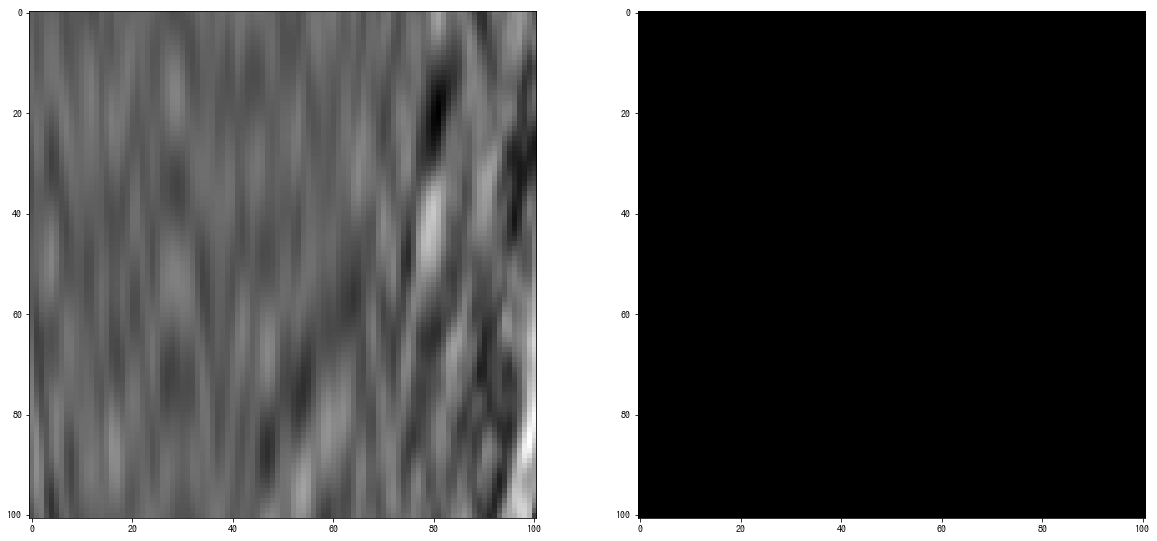

In [17]:
img_id = "1f1cc6b3a4"

plt.figure(figsize=(20, 10))

img = load_img("../../data/original/train/images/{}.png".format(img_id))
img_mask = load_img("../../data/original/train/masks/{}.png".format(img_id))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_mask)
plt.show()

In [31]:
train_dir = "../../data/original/train"
test_dir = "../../data/original/test"
im_width = 128
im_height = 128
im_channel = 1

In [32]:
train_ids = next(os.walk("{}/images".format(train_dir)))[2]
test_ids = next(os.walk("{}/images".format(test_dir)))[2]
print(len(train_ids))
print(len(test_ids))

4000
18000


# U-Netの場合、n^2の正方形である必要があるのでresize

In [36]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_channel), dtype=np.int8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)

for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = train_dir
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)



# Model Training

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arrange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
